# DeFi_Compositions
This repository provides the tools to reproduce the results shown in the paper ["Disentangling Decentralized Finance (DeFi) 
Compositions"](https://depositonce.tu-berlin.de/bitstream/11303/13867/4/Kitzler_etal_Disentangling_2021_Cover.pdf) by 
Kitzler et al. (2021), the first study on compositions of Decentralized Finance (DeFi) protocols. 
The notebook runs the scripts step-by-step. By default, the repository contains a sample data set (the full dataset is too large), as well as the sources where to find the full data we used.


## Before getting started

The code consists of several steps which can in principle be executed autonomously. But since there are a lot of preprocessing steps to reshape, adjust, and temporarily store data sets, it's recommended to follow the notebook.
Most of the processing is written in Python, the conda environment is defined in `environment.yml`  and further requirements are stored in `requirements.txt`. Parts of the analysis and plotting sections are written in R and can be executed with the rpy2-implementation. The conda environment already contains some R-packages and further libraries from the `requirements.csv` file will be installed within the notebook.

### Config file

This is a short description of the yaml-file to adjust the template in the upcoming step.

The config file `config.yaml` contains a pointer (directory paths) to the sources and destination folders. 

* **path_prot_colors** (read): Pre-defined color palette for DeFi-protocols to provide consitent plots. We provide a sample file `./data/protocol_colors.csv`.
* **path_seed_data** (read): Seed addresses to identify account addresses for each DeFi protocol. We provide our manually curated ground-truth lists of protocol-specific addresses in `path_seed_data`, based on off-chain public sources of information, such as protocol websites and related documentation. 
* **path_chain_data** (read): The analysis uses trace-data of the OpenEthereum client and ethereum-etl (https://github.com/blockchain-etl/ethereum-etl). The folder must contain the traces of the corresponding block-range and all contract creations, starting from genesis (block 0). The samples of the on-chain data are stored in the ```./data/1_chain_data/``` folder:
* **path_offchain_data** (read): The folder contains further information, not found on the blockchain. Human-readable function signatures help to understand the executed code account transactions. Sample data from the 4Byte lookup service (https://www.4byte.directory/) are provided in `./data/1_offchain_data/ethereum.functionsignatures.csv`. For statistical reasons, the total value locked (tvl) has been manually curated from historical data of (https://www.defipulse.com/) and stored in `./data/1_offchain_data`.
* **path_preprocess_data** (read/write): Folder for temporal and permanent (e.g. networks) preprocessing data.
* **path_building_block_data** (read/write): Folder for building blocks.


# 0. Initial Steps
## 0.1 Set path
Before getting started, make sure that the working directory is correctly set to the root directory.

In [ ]:
import os

os.getcwd()
#os.chdir("./..") # change directory if necessary to dir root

Load the rpy2 *R-magic* implementation to execute R code.

In [2]:
%load_ext rpy2.ipython

Also, check (or change) the R working directory.

In [ ]:
%R getwd()
# %R setwd("./..") # R # change directory if necessary to root of dir

## 0.2 Import libraries

Import Python libraries for preprocessing steps and building block extraction.

In [4]:
import scripts.basicFun as bf
import scripts.preprocess as pr
import scripts.building_blocks as bb
import scripts.case_study as cs
import scripts.building_blocks_plot_tree as bbpt

Load R requirements (packages and version), install them (if necessary), and import the libraries. Eventually re-run the script, if the library import is not working directly after the install.

In [5]:
%%R 
# read R requirement-csv
requirements <- read.table(file = "./requirements.csv", header = TRUE, stringsAsFactors=FALSE, sep = ",")

In [6]:
%%R 
# install not available package and import libraries

for(l in 1:dim(requirements)[1]){
    #print(requirements[l,1])
    if(!require(requirements[l,1],  character.only = TRUE))
        install.packages(requirements[l,1], version = requirements[l,2])
        library(requirements[l,1], character.only = TRUE)
}

R[write to console]: Loading required package: tikzDevice

R[write to console]: Loading required package: treemap

R[write to console]: Loading required package: ggfittext

R[write to console]: Loading required package: ggalluvial

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: egg

R[write to console]: Loading required package: gridExtra



## 0.3 Define parameter
The block-range of the Ethereum blockchain has to be defined. In the paper we used the range from 01-Jan-2021 (block 11,565,019) to 05-Aug-2021 (block 12,964,999). The corresponding traces for this range must be available in the on-chain folder and all the contract creations, starting from genesis (block 0)!
Further, two limit parameters could be defined, to only use a certain fraction of the trace data, which is mainly useful for testing.

In [7]:
# default
blocks = (14000000,14000999) # block range for sample data
n = 1e6  # number of files
l = 1e6  # number of lines

## 0.4 Create Seed
 from preprocess.py

### Extract contract creations from chain-data
First, all accessible trace files from the Ethereum blockchain will be read and contract-creation transactions will be extracted and stored. Implementation of ERC20 interfaces will be detected and all contract addresses and their ERC20 compatibility will be stored.

In [ ]:
# extract contracts
# if (args.function in ['contracts', 'all']):
pr.extractContractCreations(block_range=blocks)
## read all trace-files (csg.gz) from path_chain_data
## filter for 'create'-trace-type
## detect ERC20 tokens from method output
## concat all traces
## write "trace_creations.csv.gz" to path_preprocess_data/contract_creations
## write "contracts.csv.gz" to path_preprocess_data/contract_creations

### Create method signatures
Read the Ethereum signature functions and create a unique data set, so that every 4-byte function signature corresponds to a method name

In [9]:
# create signatures 
# if (args.function in ['creaSig', 'create', 'all']):
pr.processMethodSignatures()
## read path_offchain_data/'ethereum.functionsignatures.csv'
## create unique data set: methodId <-> methodName
## write to path_preprocess_data/'method_signatures.csv'

data shape: (451299, 3)
length of unique data:155027
Method processMethodSignatures finished


### Create protocol addresses from seed 
Collect protocol seed addresses from sub-folders and create one csv-file.

In [10]:
# create protocol addresses from seed folders
# if (args.function in ['creaPro', 'create', 'all']):
pr.createProtocolAddresses()
## read all csv-files from path_seed_data/protocols
## merge them
## write 'Protocol_Addresses.csv' to path_preprocess_data

create Protocol Addresses finished


### Expand seed addresses by heuristic
Use the extension heuristic (defined in the paper) and add for each address also its' created contracts to the dataset.

In [11]:
#if (args.function in ['extPro', 'create', 'all']):
pr.extandProtocolAddresses()
## read 'trace_creations.csv.gz' from path_preprocess_data/contract_creations
## read seed addresses 'Protocol_Addresses.csv' from path_preprocess_data
## run extension heuristic
## write to extended seed 'Protocol_Addresses_expanded.csv.gz' to path_preprocess_data

Expanded Protocol Addresses finished


## 0.5 Get summaries
from preprocess.py


### Summary table of address affiliations
Create summary tables for the seed addresses and their protocol affiliations

In [12]:
pr.get_addr_summary(outpath = None)

,type,protocol,seed,seed extended
0,assets,badger,64,68
1,assets,convex,22,62
2,assets,fei,40,38
3,assets,harvestfinance,101,105
4,assets,renvm,15,15
5,assets,vesper,44,44
6,assets,yearn,3,3
7,derivatives,barnbridge,40,40
8,derivatives,dydx,38,38
9,derivatives,futureswap,9,9


### Total value locked (TVL) from DeFi Pulse
Use off-chain data from DeFi-Pulse (https://www.defipulse.com/) to provide a summary of the TVL for each DeFi protocol. Data was collected by using internet archive (https://archive.org/web/)

In [13]:
# for each protocol [%]
pr.get_tvl(None)

Name                      Category
1inch Liquidity Protocol  DEXes        0.515948
88mph                     Lending      0.047362
Aave                      Lending     13.309862
Alchemix                  Lending      0.286855
Alpha Homora              Lending      1.477943
                                        ...    
dYdX                      Lending      0.181684
mStable                   Assets       0.080160
xDai                      Payments     0.118935
yAxis                     Assets       0.068340
yearn.finance             Assets       3.541124
Length: 120, dtype: float64

# 1. Preprocess
from preprocess.py

## 1.1 Filter trace 
Read all trace-files (regarding the block-range) and filter them, where the external transaction goes to one of the extended seed addresses. The method uses all filtered traces regardless of whether the transaction has been an error (e.g. out-of-gas, reverted). Additional off-chain information will be added and the filtered traces the stored in the preprocess-data subfolder.

In [ ]:
## find all trace-**csv.gz-files from path_chain_data
## reduce to all traces-files that have an overlap with the block range
## for each traces files:
### read trace file
### filter traces by ext. seed addr.
### merge additional off-chain info: e.g. assigned protocol to address
### write filtered trace file 'trace_*_fil.csv.gz' to path_preprocess_data + "/filtered_traces"

pr.filterFiles(file_numbers=n, block_range=blocks)


### Aggregate trace files 
As a preprocessing step for the network creation, read the filtered files and count for each unit (from-&to-address + external/intern tx.) the number of appearances.

In [ ]:
# agg number of transactions between each pair of addresses
## find all traces from path_preprocess_data + "filtered_traces"
## reduce to all traces-files that have an overlap with the block range
## for each trace-file
### read trace file
### filter by block range
### define external and internal as transactions_type
### agg traces: count group-by from+to+transactions_type
## concat all and sum group-by from+to+transactions_type
## write traces_*_agg.csv.gz to path_preprocess_data + "agg_traces"

pr.aggFiles(block_range=blocks)


## 1.2 Create the Code Account Network
Use internal transactions and create a weighted, directed network of all interactions between code account (CA), where each node corresponds to one address and each link to the number of transactions between them.

In [16]:
# create ca-network from agg-traces
## read agg traces file
## filter only ca-ca interactions
## write 'defi_ca_network_*.csv.gz' to path_preprocess_data/defi_networks

pr.get_CA_network(block_range=blocks)


ca network: finished


### Create the Protocol Network
Cumulate all protocol addresses of the same protocol into a single node.

In [17]:
# create protocol-network from agg-traces
## read agg traces file
## substitute all protocol addresses with protocol name and cumulate
## write 'defi_ca_network_pro_*.csv.gz' to path_preprocess_data/defi_networks

pr.get_CA_network_pro(block_range=blocks)


pro network: finished


## 2 Network analysis

This section contains the scripts to reproduce the analysis of the DeFi CA and Protocol networks. 

### 2.1 Tables

Import the file for the network analysis and execute it.

In [18]:
import scripts.network_analysis as nwa

Execute the scripts on both networks. The parameters block_st and block_end take as input the block range defined in Section 0.3

In [19]:
nwa.network_analysis("defi_ca_network_pro",block_st = blocks[0],block_end = blocks[1])

defi_ca_network_pro  analysis: done


In [20]:
nwa.network_analysis("defi_ca_network",block_st = blocks[0],block_end = blocks[1])

defi_ca_network  analysis: done


### 2.2 Plots

Reproduce the degree distribution plot:

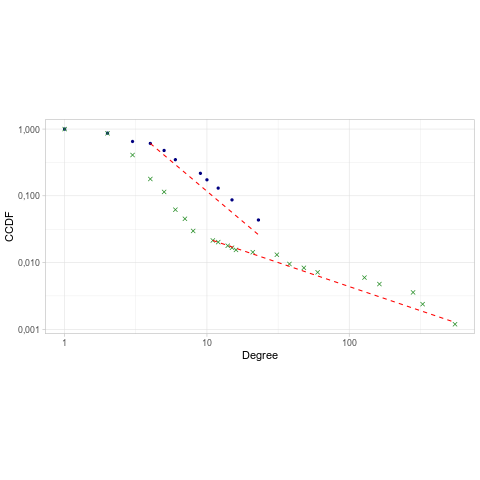

In [22]:
%%R

source("./scripts/powerlaw.R")

Reproduce the components heatmap:

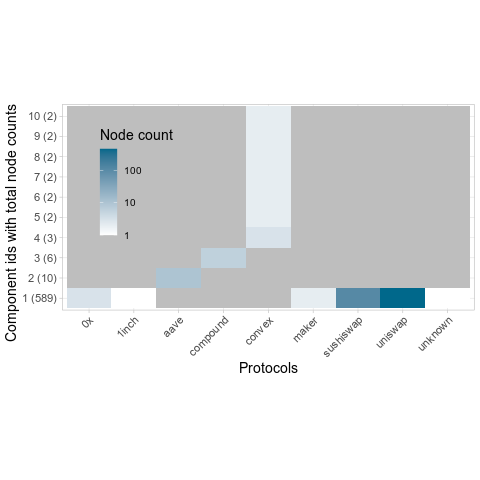

In [24]:
%%R

source("./scripts/heatmap_components.R")

# 3. Building Block

from building_blocks.py

In [25]:
# create file string to aggregated building block regarding the defined block range
from_block = blocks[0]
to_block = blocks[1]
blocks_str = str(from_block)+"-"+str(to_block)
## convert 'BB_agg_*_all.csv.gz' for R usage
blocks_str

'14000000-14000999'

## 3.1 Building Block Extraction
Read the filtered traces and extract building blocks for each DeFi-protocol using the proposed algorithm.

In [ ]:
## find all filtered traces
## reduce to all traces-files that have an overlap with the block range
## for each traces files:
### read trace file
### filter by block range
### for each tx hash
#### run building block (bb) extraction algorithm
### concat bb for trace file
### write 'trace_*_fil_building_blocks.csv.gz' to path_building_block_data/building_blocks',

bb.extractTxBuildingBlocks(file_numbers=n, block_range=blocks)


### Aggregate extracted Building Blocks
Aggregate the building blocks by grouping and counting the detected patterns.

In [27]:
# if (args.function in ['aggSubTr', 'all']):
bb.aggTxSubTraces(file_numbers=n, block_range=blocks)
## find all bb-files of path_building_block_data/building_blocks
## reduce to all bb-files that have an overlap with the block range
## for each bb-file
### count groupby without tx-hash
## concat all bb
## aggregate: sum groupby -.-
## write 'BB_agg_*_all.csv.gz' to path_building_block_data/building_blocks_agg

aggregate subtraces: finished


## 3.2 Preprocess Building Blocks
from building_blocks_processing.R

The R scripts are very computational and space intensive, 
therefore they might take long and enough RAM and DISK SPACE is required!

Read the aggregated building blocks and restructure the data set. 

In [28]:
%%R -i blocks_str
source("./scripts/building_blocks_processing.R")
# could take very long + enough RAM and DISK SPACE is required!
#preprocess_bb(file_path_bb_agg_info = paste0(path_building_block_data,"/building_blocks_agg/",blocks_str))
file_path_bb_agg_info <- paste0(path_building_block_data,"/building_blocks_agg/","BB_agg_",blocks_str,"_all.csv.gz")
file_path_bb_agg_pro <- paste0(path_building_block_data,"/building_blocks_agg/","BB_agg_pro_",blocks_str,".csv.gz")
file_path_bb_lookup <- paste0(path_building_block_data,"/building_blocks_agg/","BB_lookup_",blocks_str,".csv.gz")

preprocess_bb(file_path_bb_agg_info,file_path_bb_agg_pro,file_path_bb_lookup)


[1] "read:  ./data/5_building_block_data/building_blocks_agg/BB_agg_14000000-14000999_all.csv.gz"
[1] "agg: reduce additional information"
[1] "compute: number of sub-bb"
[1] "split-up: all sub-bb pointers for each bb"
[1] "expand: table, each sub-bb pointer in an own row"
[1] "add: protocol name to each bb"
[1] "add: appearing protocol info to original table"
[1] "count: number of appearing protocols"


Create a tree structure from initially called blocks to its' sub-blocks and finally to the atomic once, which doesn't contain any further blocks. Produce tree structures from two perspectives, regarding the instance of each tree node: either protocol or building block hash for different applications.

from building_blocks_preprocess_tree.R

In [29]:
%%R -i blocks_str

file_hash_tree <- paste0(path_building_block_data,"/building_blocks_agg/","hash_tree_",blocks_str,".csv.gz")
file_protocol_tree <- paste0(path_building_block_data,"/building_blocks_agg/","pro_tree_",blocks_str,".csv.gz")

source("./scripts/building_blocks_preprocess_tree.R")
hash_tree <- create_hash_tree(file_path_bb_agg_pro, file_path_bb_lookup, file_hash_tree, file_protocol_tree)

[1] "depth: 0"
[1] "depth: 1"
[1] "depth: 2"
[1] "depth: 3"
[1] "depth: 4"
[1] "depth: 5"
[1] "depth: 6"
[1] "depth: 7"


## 3.3 Building Blocks Analysis
from building_blocks_plots.R

Plot the building block tree structure of the first tree level

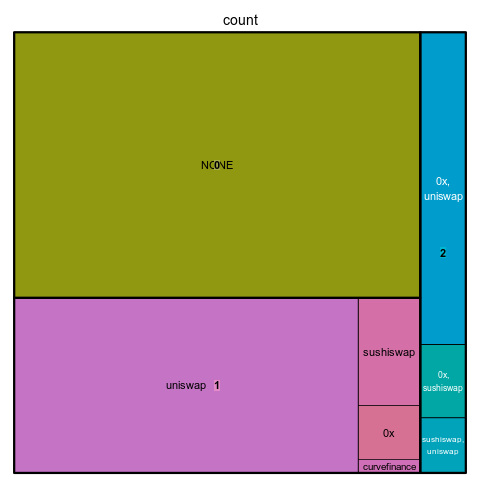

In [30]:
%%R
source("./scripts/building_blocks_plots.R")
plot_tree_map <- create_tree_map_plot(file_path_bb_agg_pro, file_hash_tree);

Plot the building blocks' protocol tree for one single protocol. Each building block can be associated with a protocol. The plot shows which different protocol building blocks are contained, starting from a specified DeFi protocol.

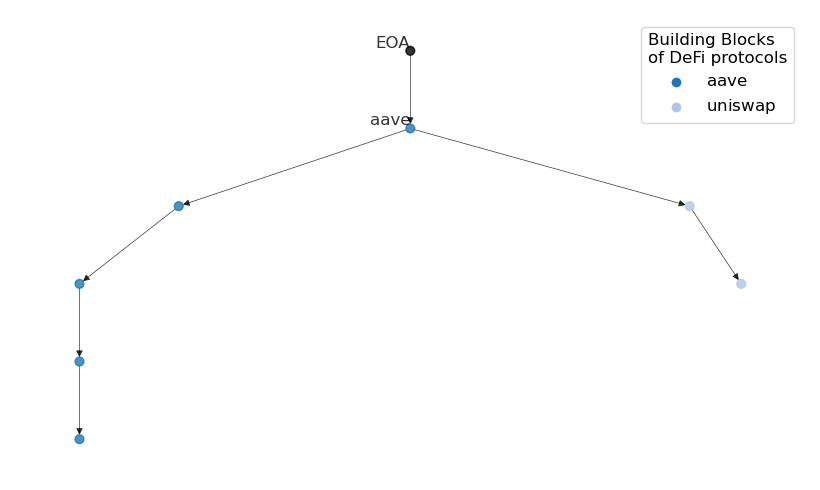

In [31]:
%matplotlib inline

file_protocol_tree = "/building_blocks_agg/"+"pro_tree_"+blocks_str+".csv.gz"

bbpt.create_pro_tree_plot(select_protocol = "aave", file_relpath_pro_tree = file_protocol_tree)

Create a heatmap of contained protocols when an external transaction has been called from a certain protocol.

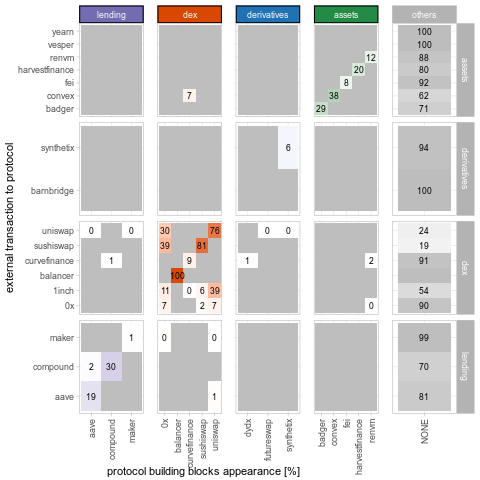

In [32]:
%%R
source("./scripts/building_blocks_plots.R")
plot_heatmap <- create_heatmap_plot(file_path_bb_agg_pro, file_hash_tree);

# 4. USDT Case Study

Case study for a hypothetical stablecoin run for USDT. The analysis shows how many building blocks of each DeFi protocols are affected directly or indirectly through dependencies in the call graph from blocks that file above.

In [33]:
%matplotlib inline

addr_token = str("0xdAC17F958D2ee523a2206206994597C13D831ec7").lower()

file_path_bb_agg_info  = "/building_blocks_agg/BB_agg_"+blocks_str+"_all.csv.gz"
file_name_token_dep = addr_token[0:6]+"_"+blocks_str+"_Protocol_Depenency.csv"

df_case_study = cs.case_study(addr_token = addr_token,
                              file_relpath_bb_agg_info = file_path_bb_agg_info,
                              fn_token_dep = file_name_token_dep)
#df_case_study.plot.bar()

./data/5_building_block_data/building_blocks_agg/BB_agg_14000000-14000999_all.csv.gz
Write: ./data/5_building_block_data/case_study/0xdac1_14000000-14000999_Protocol_Depenency.csv


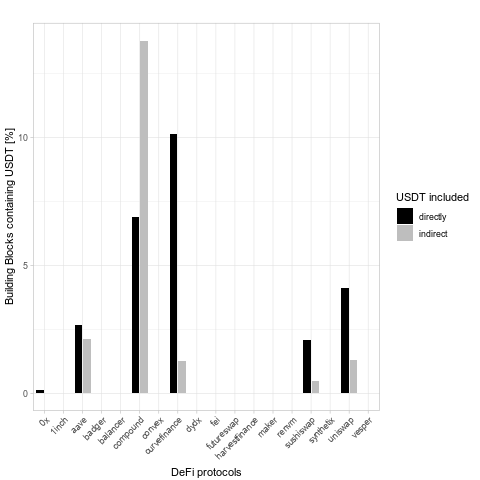

In [34]:
%%R -i file_name_token_dep
source("./scripts/usdt_plot.R")
plot_usdt_protocol_bar(fn_token_dep = file_name_token_dep)